## Example Use of NIRCam Data Simulator to generate Wide Field Slitless Exposures

The simulator is broken up into four basic stages:

1. Creation of a "seed image".
   This is generally a noiseless countrate image that contains signal
   only from the astronomical sources to be simulated. Currently, the 
   nircam_simulator package contains code to produce a seed image starting
   from object catalogs.
   
2. Disperse the seed image. 
   Use the disperser code to turn the imaging seed image into a seed 
   image containing the dispersed spectra of all sources.
   
3. Dark current prep.
   The simualted data will be created by adding the simulated sources
   in the seed image to a real NIRCam dark current exposure. This step
   converts the dark current exposure to the requested readout pattern
   and subarray size requested by the user.
   
4. Observation generator.
   This step converts the seed image into an exposure of the requested
   readout pattern and subarray size. It also adds cosmic rays and 
   Poisson noise, as well as other detector effects (IPC, crosstalk, etc).
   This exposure is then added to the dark current exposure from step 2.

Dependencies: 

1) Install GRISMCONF from https://github.com/npirzkal/GRISMCONF

The dependency below should eventually go away once GRISM_NIRCAM is packaged with
the other simulator input files in the NIRCAM_SIM_DATA environment variable
2) Install GRISM_NIRCAM (NIRCAM configuration files) from https://github.com/npirzkal/GRISM_NIRCAM  

In [1]:
# Set the NIRCAM_SIM_DATA environment variable if it is not
# set already. This is for users at STScI.
import os
datadir = '/ifs/jwst/wit/nircam/nircam_simulator_data'
os.environ['NIRCAM_SIM_DATA'] = datadir

In [2]:
# Import the three steps of the simulator. 
from nircam_simulator.scripts import catalog_seed_image
from nircam_simulator.scripts import dark_prep
from nircam_simulator.scripts import obs_generator
from nircam_simulator.scripts import wfss_simulator
from nircam_simulator.scripts import yaml_update
from NIRCAM_Gsim.grism_seed_disperser import Grism_seed

In [3]:
# For examining outputs
from glob import glob
from scipy.stats import sigmaclip
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# yaml files that contains the parameters of the
# data to be simulated
# Example yaml file shown at the bottom of this
# notebook
yamlfile1 = 'wfss_f250m_test.yaml'
yamlfile2 = 'wfss_f300m_test.yaml'
yamlfile3 = 'wfss_f410m_test.yaml'
yamlfile4 = 'wfss_f460m_test.yaml'

## First generate the "seed images" 
Each is generally a 2D noiseless countrate image that contains only 
simulated astronomical sources

In order for the disperser software to function, we need seed images
through several filters. The disperser will use the relative brightnesses
of objects in the filters to determine the shape of the continuum for each.

In [5]:
seed1 = catalog_seed_image.Catalog_seed()
seed1.paramfile = yamlfile1
seed1.make_seed()

seed2 = catalog_seed_image.Catalog_seed()
seed2.paramfile = yamlfile2
seed2.make_seed()

seed3 = catalog_seed_image.Catalog_seed()
seed3.paramfile = yamlfile3
seed3.make_seed()

seed4 = catalog_seed_image.Catalog_seed()
seed4.paramfile = yamlfile4
seed4.make_seed()

'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_pointsources.list.
Number of point sources found within the requested aperture: 513
Galaxy list input positions assumed to be in units of RA and Dec.
Galaxy list input radii assumed to be in units of a

### Look at the seed image

In [6]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar().set_label('DN/s')

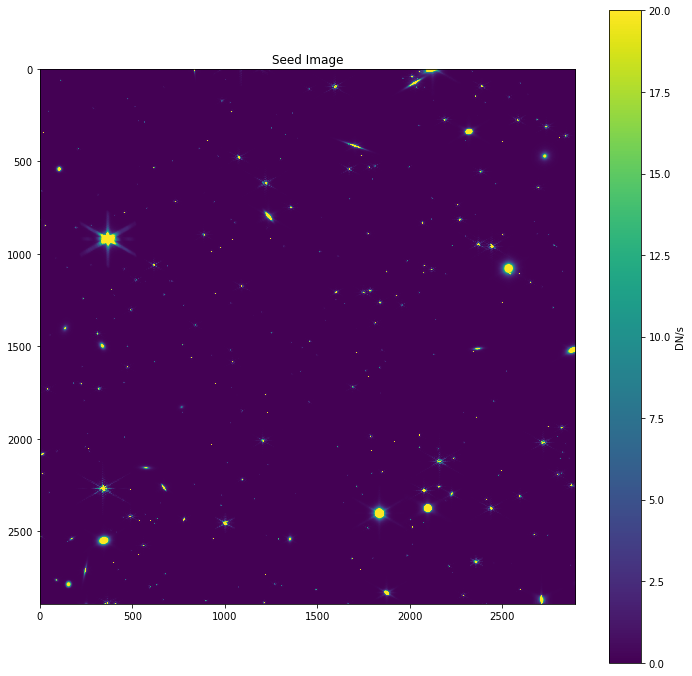

In [7]:
show(seed1.seedimage,'Seed Image',max=20)

## Disperse the seed image

In [7]:
crossing_filter = 'F444W'
module = 'A'    # 'A' or 'B'
direction = 'R' # 'R' for row or 'C' for column
image_seeds = [seed1.seed_file, seed2.seed_file, seed3.seed_file, seed4.seed_file]
#image_seeds = ['V42424024002P000000000112o_B5_F250M_seed_uncal_F250M_seed_image.fits','V42424024002P000000000112o_B5_F300M_seed_uncal_F300M_seed_image.fits','V42424024002P000000000112o_B5_F410M_seed_uncal_F410M_seed_image.fits','V42424024002P000000000112o_B5_F460M_seed_uncal_F460M_seed_image.fits']
dmode = 'mod{}_{}'.format(module.upper(),direction.upper())
loc = os.path.join(datadir,"GRISM_NIRCAM/")
t = Grism_seed(image_seeds,crossing_filter,dmode,loc)
t.observation()
t.finalize()

985 pixels to process
dir image: /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_F250M_seed_image.fits
Loaded /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_F250M_seed_image.fits wavelength: 2.503 A
dir image: /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F300M_seed_uncal_F300M_seed_image.fits
Loaded /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F300M_seed_uncal_F300M_seed_image.fits wavelength: 2.99 A
dir image: /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F410M_seed_uncal_F410M_seed_image.fits
Loaded /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F410M_seed_uncal_F410M_seed_image.fits wavelength: 4.092 A
dir image: /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F460M_seed_uncal_F460M_seed_image.fits
Loaded /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F460M_seed_uncal_F460M_seed_im

0.07114124298095703 s.
2 of 100
10 pixels loaded for dispersion...
0.07229876518249512 s.
3 of 100
10 pixels loaded for dispersion...
0.07290482521057129 s.
4 of 100
10 pixels loaded for dispersion...
0.07309174537658691 s.
5 of 100
10 pixels loaded for dispersion...
0.07439923286437988 s.
6 of 100
10 pixels loaded for dispersion...
0.07251620292663574 s.
7 of 100
10 pixels loaded for dispersion...
0.0726323127746582 s.
8 of 100
10 pixels loaded for dispersion...
0.06679749488830566 s.
9 of 100
10 pixels loaded for dispersion...
0.07439398765563965 s.
10 of 100
10 pixels loaded for dispersion...
0.06673574447631836 s.
11 of 100
10 pixels loaded for dispersion...
0.0720670223236084 s.
12 of 100
10 pixels loaded for dispersion...
0.07176661491394043 s.
13 of 100
10 pixels loaded for dispersion...
0.07216787338256836 s.
14 of 100
10 pixels loaded for dispersion...
0.06424450874328613 s.
15 of 100
10 pixels loaded for dispersion...
0.07554936408996582 s.
16 of 100
10 pixels loaded for disp

### Look at the dispersed seed image

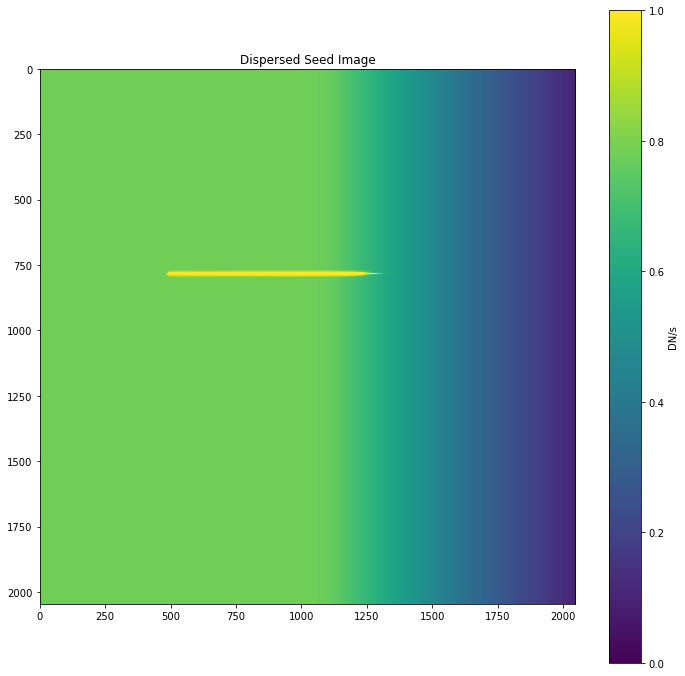

In [8]:
# In this case, the short exposure time (30 seconds)
# combined with the dispersed background signal means
# that only the brightest source is visible in the 
# dispersed seed image
show(t.final,'Dispersed Seed Image',max=1)

## Prepare the dark current exposure
This will serve as the base of the simulated data.
This step will linearize the dark current (if it 
is not already), and reorganize it into the 
requested readout pattern and number of groups.

In [9]:
d = dark_prep.DarkPrep()
d.paramfile = yamlfile1
d.prepare()

'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/dq_init.cfg for newRamp:dq_configfile input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/saturation.cfg for newRamp:sat_configfile input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam

### Look at the dark current 
For this, we will look at an image of the final group
minus the first group

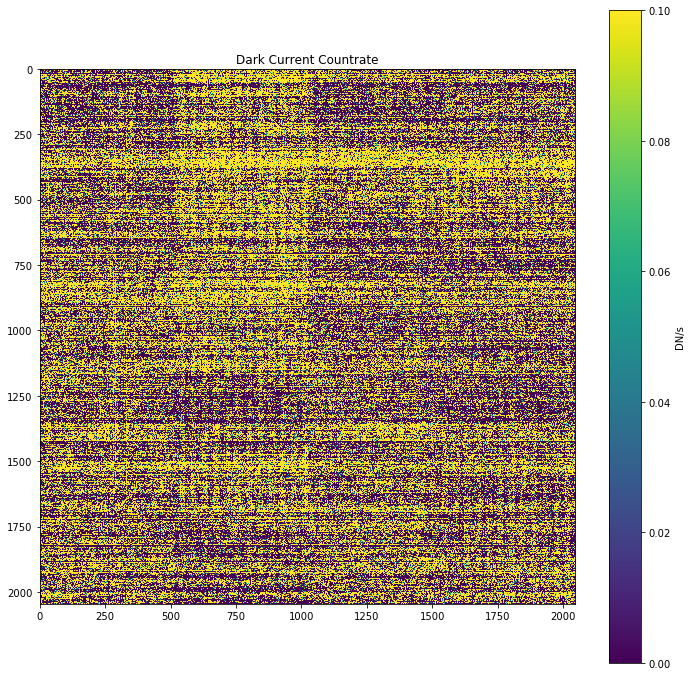

In [11]:
exptime = d.linDark.header['NGROUPS'] * seed1.frametime
diff = (d.linDark.data[0,-1,:,:] - d.linDark.data[0,0,:,:]) / exptime
show(diff,'Dark Current Countrate',max=0.1)

## Create the final exposure
Turn the seed image into a exposure of the 
proper readout pattern, and combine it with the
dark current exposure. Cosmic rays and other detector
effects are added. 

The output can be either this linearized exposure, or
a 'raw' exposure where the linearized exposure is 
"unlinearized" and the superbias and 
reference pixel signals are added, or the user can 
request both outputs. This is controlled from
within the yaml parameter file.

In this case, we need a new yaml file, since the yaml
files used eariler were used to generate the imaging mode
seed images. 

In [12]:
y = yaml_update.YamlUpdate()
y.file = yamlfile1
y.filter = crossing_filter
y.pupil = 'GRISM' + direction
y.outname = 'wfss_dispersed_{}_{}.yaml'.format(dmode,crossing_filter)
y.run()

In [13]:
obs = obs_generator.Observation()
obs.linDark = d.prepDark
obs.seed = t.final
obs.segmap = seed1.seed_segmap # not used in this step
obs.seedheader = seed1.seedinfo # not used in this step
obs.paramfile = y.outname
obs.create()


Running observation generator....

'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/nircam_filter_pupil_pairings.list for Reffiles:filtpupilcombo input file
'config' specified: Using /home/hilbert/.cache/Python-Eggs/nircam_simulator-1.0-py3.5.egg-tmp/nircam_simulator/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Requested readout pattern RAPID is va

WCS info for /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits complete.


Final output integration saved to /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits
Final linearized exposure saved to:
/ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits


WCS info for /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_dispersed_GRISMR_crossing_F444W_uncal.fits complete.


Final output integration saved to /ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_dispersed_GRISMR_crossing_F444W_uncal.fits
Final raw exposure saved to
/ifs/jwst/wit/nircam/hilbert/testtest/V42424024002P000000000112o_B5_F250M_seed_uncal_dispersed_GRISMR_crossing_F444W_uncal.fits


### Examine the final output image
Again, we will look at the last group minus the first group, from the linear output integration

In [15]:
linfile = '/ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_linear.fits'
linfile = 'V42424024002P000000000112o_B5_F250M_seed_linear_dispersed_GRISMR_crossing_F444W_linear.fits'
with fits.open(linfile) as h:
    lindata = h[1].data
    header = h[0].header

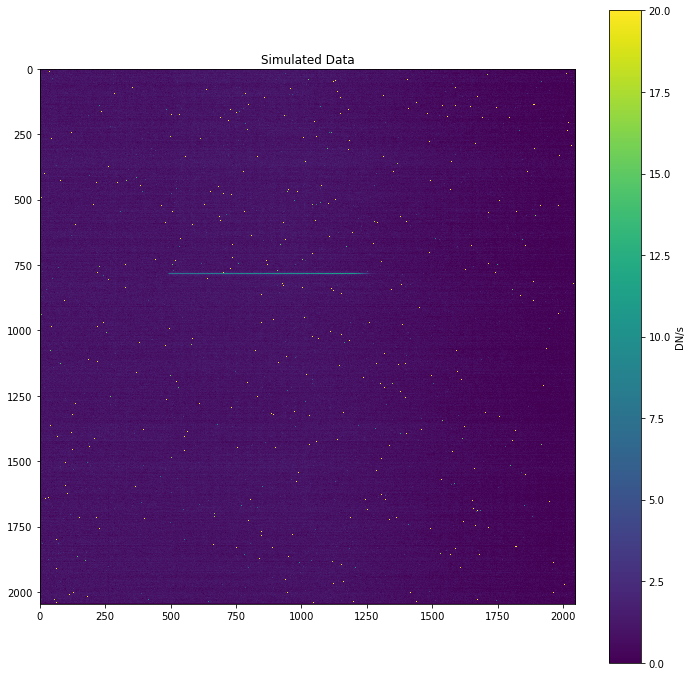

In [16]:
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime
show(diffdata,'Simulated Data',min=0,max=20)

/user/hilbert/anaconda2/envs/cleansimtest2/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


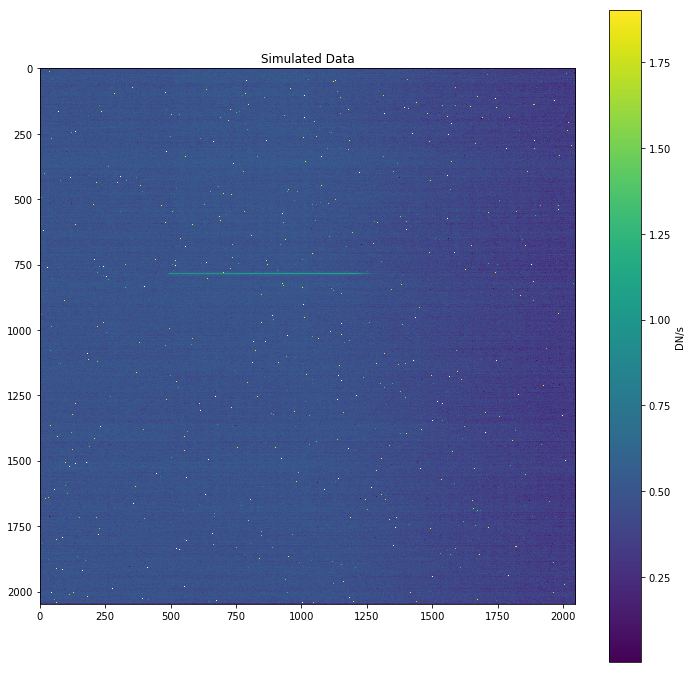

In [18]:
# Show on a log scale, to bring out the presence of the dark current
# Noise in the CDS image makes for a lot of pixels with values < 0,
# which makes this kind of an ugly image. Add an offset so that
# everything is positive and the noise is visible
offset = 2.
plt.figure(figsize=(12,12))
plt.imshow(np.log10(diffdata+offset),clim=(0.001,np.log10(80)))
plt.title('Simulated Data')
plt.colorbar().set_label('DN/s')

## For convenience, combine the steps above into a single function.

Currently, the wfss_simulator function below only works for the simplest WFSS case. Several imaging mode seed images are created. These are fed into the disperser to produce the dispersed seed image. This is then combined with the dark current observation to create the simulated dispersed data. 

In [ ]:
# First, run all steps of the imaging simulator for yaml file #1
yfiles = [yamlfile1,yamlfile2,yamlfile3,yamlfile4]
crossing_filter = 'F444W'
disp_dir = 'R'
module = 'A'
dark_prep_output = 'V42424024002P000000000112o_B5_F250M_seed_uncal_linear_dark_prep_object.fits'


m = wfss_simulator.WFSSSim()
m.paramfiles = yfiles
m.crossing_filter = crossing_filter
m.direction = disp_dir
m.module = module
# optionally, to skip the dark_prep step if you already 
# have the appropriate dark current file that has been
# output by a prior run of dark_prep, you can choose to
# skip the dark_prep step using the line below

#m.override_dark = dark_prep_output

m.create()

### Each yaml file will simulate an exposure for a single pointing using a single detector.

## Running Multiple Simulations

### In Series

In [ ]:
paramlist = [[yaml_a5_filt1_pointing1,yaml_a5_filt2_pointing1,yaml_a5_filt3_pointing1],
             [yaml_a5_filt1_pointing2,yaml_a5_filt2_pointing2,yaml_a5_filt3_pointing2],
             [yaml_b5_filt1_pointing3,yaml_b5_filt2_pointing3,yaml_b5_filt3_pointing3],
             [yaml_b5_filt1_pointing4,yaml_b5_filt2_pointing4,yaml_b5_filt3_pointing4]]
cr_filts = ['F444W','F444W','F356W','F410M']
dirs = ['R','R','C','C']
mods = ['A','A','B','B']

In [ ]:
# Function to run many simulations
# in series
def many_wfss(paramfiles,filts,directions,modules):
    for files, filt, direct, mod in zip(paramlist, cr_filts, dirs, mods):
        m = wfss_simulator.WFSSSim()
        m.paramfiles = files
        m.crossing_filter = filt
        m.direction = direct
        m.module = mod
        m.create()

### In Parallel

In [ ]:
# Simulations do not depend on
# one another, so we can parallelize
# to speed things up.

#STILL NEED TO TEST THIS
from multiprocessing import Pool
n_procs = 5 # number of cores available
with Pool(n_procs) as pool:
    pool.map(make_sim,paramlist)

## Generating input yaml files

For convenience, observing programs with multiple pointings 
and detectors can be simulated starting with the program's 
APT file. The xml and pointings files must be exported from 
APT, and are then used as input into a tool that will
generate a series of yaml input files.

In [5]:
from nircam_simulator.scripts import apt_inputs, yaml_generator

In [30]:
THIS STILL NEEDS TO BE TESTED FOR THE WFSS CASE. IMAGING CASE WORKS

# Create a series of data simluator input yaml files
# from APT files
yam = yaml_generator.SimInput()
yam.input_xml = 'example_imaging_program.xml'
yam.pointing_file = 'example_imaging_program.pointing'
yam.siaf = '/ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv'
yam.output_dir = './'
yam.simdata_output_dir = './'
yam.observation_table = 'observation_list.yaml'
yam.use_JWST_pipeline = True
yam.use_linearized_darks = False
yam.datatype = 'linear'
yam.reffile_setup()
yam.create_inputs()

Using /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/example_imaging_program.xml, /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/example_imaging_program.pointing, and /ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv to generate observation table.
Final csv exposure list written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/Observation_table_for_example_imaging_program.xml.csv
Updated observation table file saved to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/Observation_table_for_example_imaging_program.xml_with_yaml_parameters.csv
Output file written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001101_B1_F115W.yaml
Output file written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P

In [31]:
yfiles = glob(os.path.join(yam.output_dir,'V*yaml'))

### Example yaml input file

Entries listed as 'config' have default files that are present in the 
config directory of the repository. The scripts are set up to 
automatically find and use these files. The user can replace 'config'
with a filename if they wish to override the default.

In general, if 'None' is placed in a field, then the step that uses
that particular file will be skipped.

Note that the linearized_darkfile entry overrides the dark entry, unless
linearized_darkfile is set to None, in which case the dark entry will be
used.

Use of a valid readout pattern in the readpatt entry will cause the 
simulator to look up the values of nframe and nskip and ignore the 
values given in the yaml file.